In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

In [3]:
#read .csv files
fish_length_data = pd.read_csv(f"Data/fish_length_info/fish_length_clean.csv",converters={"lake_id": str})
fish_catch_data = pd.read_csv(f"Data/fish_cpue_info/fish_cpue_clean.csv",converters={"lake_id": str})
lakes_data = pd.read_csv("Data/lake_info/lake_information_clean.csv", converters={"lake_id": str})
fish_id = pd.read_csv("Data/fish_id_info/fish_id_list.csv")
city_data = pd.read_csv("Data/city_info/MN_cities_info.csv")

In [49]:
#user input Minnesota city name, string
city = "New Ulm"
#user input 3 digit fish_id, string
species = "WAE"
#user input search distance in miles from city, float
travel = 60
#user input number of results desired
requested_results = 8
#user input YYYY-MM-DD format, datetime64
start_date = np.datetime64("2000-01-31")
#user input gear from gear list, string, optional
gear = "Standard gill nets"

In [50]:
# get city lat and lon from city data csv file
lon = city_data.loc[city_data["city_name"] == city, "city_longitude"].values[0]
lat = city_data.loc[city_data["city_name"] == city, "city_latitude"].values[0]

In [70]:
#add methods

#convert coordinate lat or lon from degrees to radians; coordinate = -94.728528
def get_radians(coordinate):
    radian = coordinate*np.pi/180
    return radian

#calculate distance between 2 geographic degree points; lon1 = -94.728528 , lat1 = 44.308025
def get_distance(lat1, lon1, lat2, lon2):
    distance = np.arccos(np.sin(get_radians(lat1))*np.sin(get_radians(lat2)) + \
                         np.cos(get_radians(lat1))*np.cos(get_radians(lat2)) * \
                         np.cos(get_radians(lon2)-get_radians(lon1)))*3958.8
    return distance

#input fish_catch_df as dataframe, lakes as list of lake id, species as str, start_date as datetime64, gear as str
#returns list of cpue column in dataframe for boxplot
def get_cpue_box(df, lakes, species, start_date=np.datetime64("1900-01-31"), gear="Standard gill nets"):
    cpue_boxplot_list = []
    for lakeid in lakes:
        species_cpue = df.loc[(df["species"] == species) & \
                            (df["gear"] == gear) & \
                            (df["survey_date"] >= start_date) & \
                            (df["lake_id"] == lakeid), "cpue"]
        cpue_boxplot_list.append(species_cpue)
    return cpue_boxplot_list

#uses a list format to plot cpue boxplots
def plot_cpue_box(fishlist, lakes):
    plt.boxplot(fishlist)
    labels = lake_names
    ticks = range(1, len(lakes)+1)
    plt.xticks(ticks=ticks, labels=labels, rotation=45, ha="right")
    plt.title(species_name)
    plt.show()

#input length_df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#returns dictionary of fish_count column in dataframe for histogram, format {lake ID:[0,0,1,2,2,2,2,3,3]}
def get_length_hist(df, lakes, species, start_date=np.datetime64("1900-01-31")):
    fishdict = {}
    for lakeid in lakes:
        #sort by lake and species
        species_length = df.loc[(df["species"] == species) & \
                                    (df["survey_date"] >= start_date) & \
                                    (df["lake_id"] == lakeid), "fish_count"]        
        fish_list = []
        for _ in species_length.values:
            sample = _.replace("[","").replace("]","").split(",")
            sample = [int(x) for x in sample]
            fish_list = sample + fish_list
        fishdict[lakeid] = fish_list
    return fishdict

#Uses a dictionary format {lake ID:[0,0,1,2,2,2,2,3,3]} to plot fish length histograms
def plot_length_hist(fishdict):
    i = -1
    for lakeid in fishdict.keys():
        i += 1
        if bool(fishdict[lakeid]) == False:
            print(f"{lakeid} did not return results for the timeframe or species specified.")
        else:
            plt.hist(fishdict[lakeid])
            plt.xlabel("Size in Inches")
            plt.ylabel("Number sampled")
            plt.title(f"{lake_names[i]} lengths for {species_name}")
            plt.show()

#input string data series with rows of "[1,1,2,2,2,3,4,7,7,7]"
#returns fish_count series column as a list of float averages e.g. [5.1, 4.6, 8.8]
def fish_length_averager(dfseries):
    fish_length_averages = []
    for row in dfseries:
        #change string row to a list
        sample = row.replace("]","").replace("[","").replace(" ","").split(",")
        #convert list items to integer
        sample = [int(x) for x in sample if x != 0]
        fish_length_averages.append(np.mean(sample))
    return fish_length_averages

#input cpue_df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#function to return cpue data for scatterplot using fish length dataframe as df, lakes as a list, species as str, and start date as np.datetime64("1900-01-31") format
def get_cpue_scatter(df, lakes, species, start_date=np.datetime64("1900-01-31"), gear="Standard gill nets"):
    lake_scatter_cpue_list = []
    for lakeid in lakes:
        species_cpue = df.loc[(df["species"] == species) & \
                            (df["survey_date"] >= start_date) & \
                            (df["gear"] == gear) & \
                            (df["lake_id"] == lakeid), "cpue"]
        lake_scatter_cpue_list.append(species_cpue)
    return lake_scatter_cpue_list

#input length_df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#function to return avg species length data for scatterplot using fish length dataframe as df, lakes as a list, species as str, and start date as np.datetime64("1900-01-31") format
def get_avglen_scatter(df, lakes, species, start_date=np.datetime64("1900-01-31")):
    lake_scatter_length_list = []
    for lakeid in lakes:
        species_length = df.loc[(df["species"] == species) & \
                                    (df["survey_date"] >= start_date) & \
                                    (df["lake_id"] == lakeid), "average_length"]
        lake_scatter_length_list.append(species_length)
    return lake_scatter_length_list

#input df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#function to return survey date data for scatterplot using dataframe as df, lakes as a list, species as str, and start date as np.datetime64("1900-01-31") format
def get_survey_date_scatter(df, lakes, species, start_date=np.datetime64("1900-01-31"), gear="Standard gill nets"):
    lake_scatter_survey_date_list = []
    for lakeid in lakes:
        try:
            species_survey_date = df.loc[(df["species"] == species) & \
                                (df["gear"] == gear) & \
                                (df["survey_date"] >= start_date) & \
                                (df["lake_id"] == lakeid), "survey_date"]
        except KeyError:
            species_survey_date = df.loc[(df["species"] == species) & \
                                (df["survey_date"] >= start_date) & \
                                (df["lake_id"] == lakeid), "survey_date"]            
        lake_scatter_survey_date_list.append(species_survey_date)
    return lake_scatter_survey_date_list

#input df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#function to return numeric survey date data for regression line using dataframe as df, lakes as a list, species as str, and start date as np.datetime64("1900-01-31") format
def get_numeric_survey_date_regress(df, lakes, species, start_date=np.datetime64("1900-01-31"), gear="Standard gill nets"):
    lake_scatter_numeric_survey_date_list = []
    for lakeid in lakes:
        try:
            lake_scatter_numeric_survey_date = df.loc[(df["species"] == species) & \
                                (df["gear"] == gear) & \
                                (df["survey_date"] >= start_date) & \
                                (df["lake_id"] == lakeid), "numeric_survey_date"]
        except KeyError:
            lake_scatter_numeric_survey_date = df.loc[(df["species"] == species) & \
                                (df["survey_date"] >= start_date) & \
                                (df["lake_id"] == lakeid), "numeric_survey_date"]            
        lake_scatter_numeric_survey_date_list.append(lake_scatter_numeric_survey_date)
    return lake_scatter_numeric_survey_date_list

#input fish= length or cpue series int, sdate= survey date series datetime64, lakes= [list of lake id], ytext= ylabel value
#scatter plot average lengths per lake
def plot_scatter(fish, sdate, lakes, ytext=""):
    for _ in range(len(lakes)):
        plt.plot(sdate[_],fish[_], label=lake_names[_])
    plt.title(f"{ytext} measurements for {species_name}")
    plt.ylabel(f"{species_name} {ytext}")
    plt.xlabel("Date")
    plt.xticks(rotation=45, ha="right")
    plt.legend(loc="best")
    plt.show()
    
#plot regression lines with scatter plots for each lake
def plot_regression_scatter(fish, sdate, ndate, lakes, ytext=""):
    print("Notes:")
    for lake in range(len(lakes)):
        if len(ndate[lake]) == 0:
            print(f"Survey Data Empty for {lakes[lake]}")
        elif len(ndate[lake]) == 1:
            print(f"Only 1 data point exists for {lakes[lake]}")
        else:
            regression_values = linregress(ndate[lake],fish[lake])
            fig, ax1 = plt.subplots(1,1)
            fig.suptitle(f"{ytext} trend for {lake_names[lake]}")
            ax1.scatter(sdate[lake],fish[lake], label=lake_names[lake])
            ax1.set_ylabel(f"{species_name} {ytext}")
            ax1.set_xlabel(f"R value = {regression_values.rvalue}")
            plt.xticks(rotation=45)
            ax2 = ax1.twiny()
            ax2.plot(ndate[lake],(regression_values.slope*ndate[lake] + regression_values.intercept))
    plt.show()

In [52]:
#add numeric survey date column as an integer to fish CPUE
fish_catch_df = fish_catch_data
fish_catch_df["survey_date"] = pd.to_datetime(fish_catch_df["survey_date"],format="%Y-%m-%d")
fish_catch_df["numeric_survey_date"] = pd.to_numeric(fish_catch_df["survey_date"])
fish_catch_df = fish_catch_df.sort_values("survey_date")
fish_catch_df = fish_catch_df.reset_index(drop=True)

In [53]:
#add numeric survey date column as an integer to fish length
fish_length_df = fish_length_data
fish_length_df["survey_date"] = pd.to_datetime(fish_length_df["survey_date"],format="%Y-%m-%d")
fish_length_df["numeric_survey_date"] = pd.to_numeric(fish_length_df["survey_date"])
fish_length_df = fish_length_df.sort_values("survey_date")
fish_length_df = fish_length_df.reset_index(drop=True)

In [54]:
#get list of lakes within travel distance 
closeby = lakes_data.loc[(get_distance(lat, lon, lakes_data["lake_latitude"], lakes_data["lake_longitude"]) < travel)]
cpue_data = fish_catch_df.loc[(fish_catch_df["species"] == species) & \
                              (fish_catch_df["survey_date"] >= start_date) & \
                              (fish_catch_df["gear"] == gear)]
cpue_data = cpue_data.groupby(["lake_id", "species"]).median() ["cpue"]
species_name = fish_id.loc[fish_id["fish_id"] == species, "fish_description"].values[0]
species_name

'Walleye'

In [55]:
#merge results with CPUE data and find top 5
results = closeby.merge(cpue_data, how="inner", on="lake_id")
results = results.sort_values("cpue", ascending=False)
lakes = list(results["lake_id"])[0:requested_results]
lake_names = [lakes_data.loc[lakes_data["lake_id"] == x, "lake_name"].values[0] for x in lakes]
lakes

['34016900',
 '34007600',
 '17002000',
 '32005707',
 '17005400',
 '87003000',
 '07009800',
 '40010900']

In [56]:
#create date series for length scatter plots and regression lines
length_sdate = get_survey_date_scatter(fish_length_df, lakes, species, start_date)
length_ndate = get_numeric_survey_date_regress(fish_length_df, lakes, species, start_date)

In [57]:
#create date series for cpue scatter plots and regression lines
cpue_sdate = get_survey_date_scatter(fish_catch_df, lakes, species, start_date)
cpue_ndate = get_numeric_survey_date_regress(fish_catch_df, lakes, species, start_date)

In [58]:
#filter and prepare a CPUE list for box plots
cpuelist = get_cpue_box(fish_catch_df, lakes, species, start_date)

In [59]:
#filter and prepare a list of lengths for histogram plots
lengthdict = get_length_hist(fish_length_df, lakes, species, start_date)

In [60]:
#create fish CPUE data series for scatter plot and regression line
fish_cpue = get_cpue_scatter(fish_catch_df, lakes, species, start_date)

In [61]:
#create fish length data series for scatter plot and regression line
fishavglength = get_avglen_scatter(fish_length_df, lakes, species, start_date)

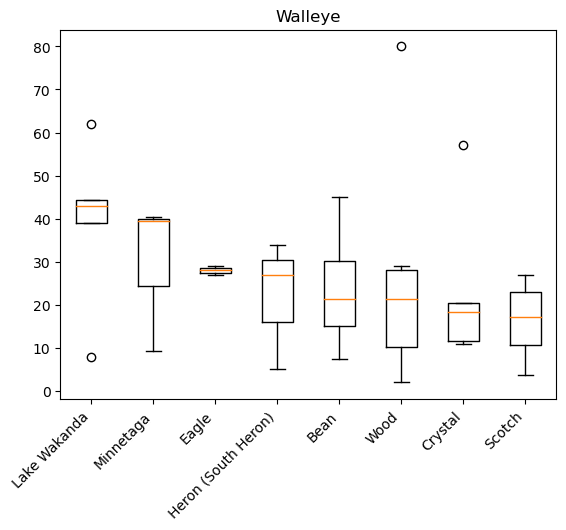

In [62]:
#plot boxplot of CPUE per lake
plot_cpue_box(cpuelist, lakes)

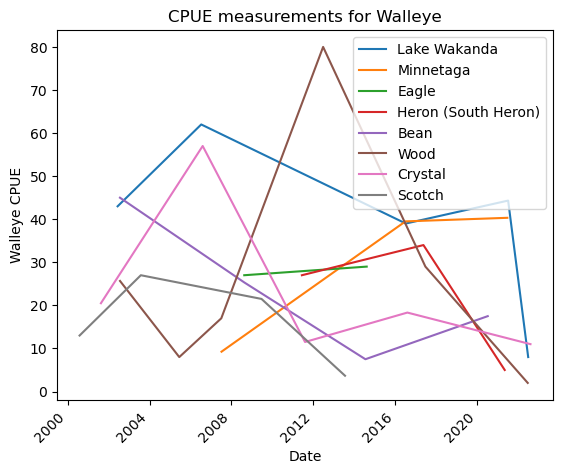

In [71]:
#plot scatter of CPUE per lake
plot_scatter(fish_cpue, cpue_sdate, lakes, ytext="CPUE")

Notes:


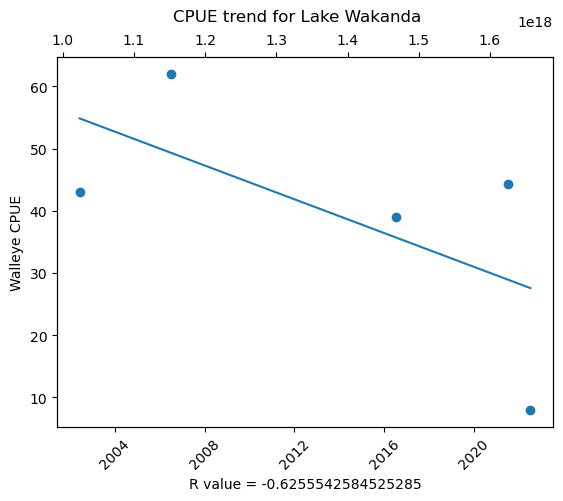

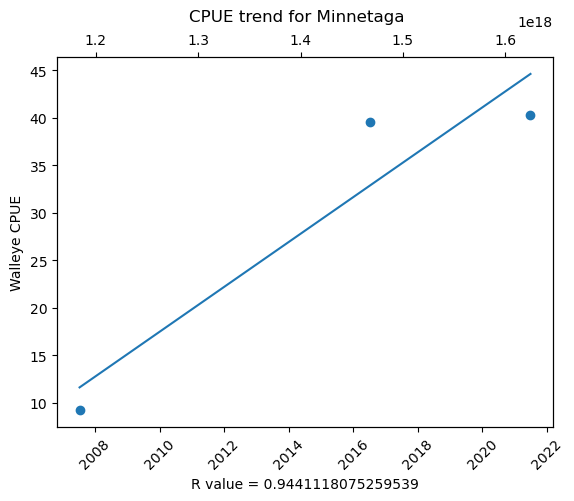

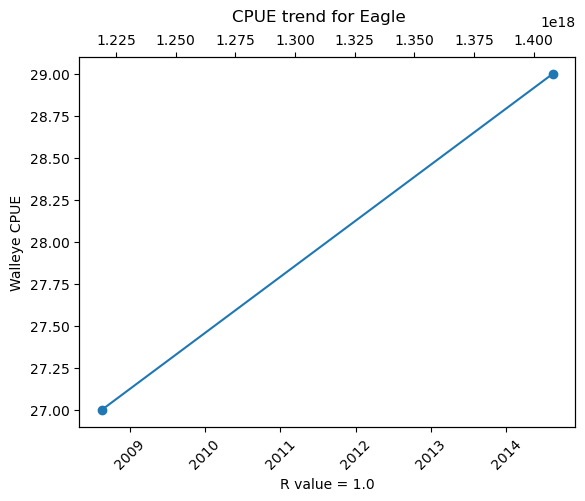

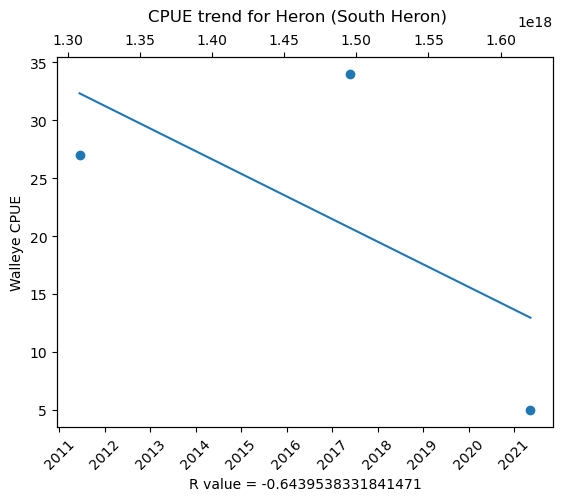

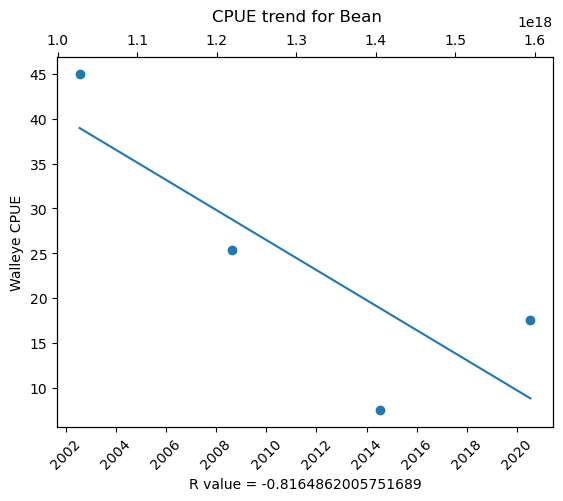

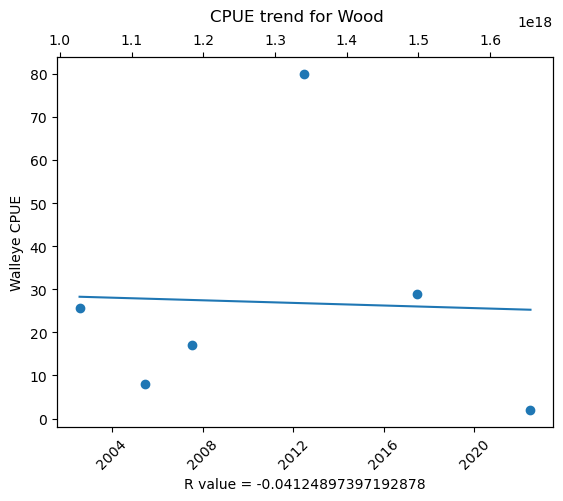

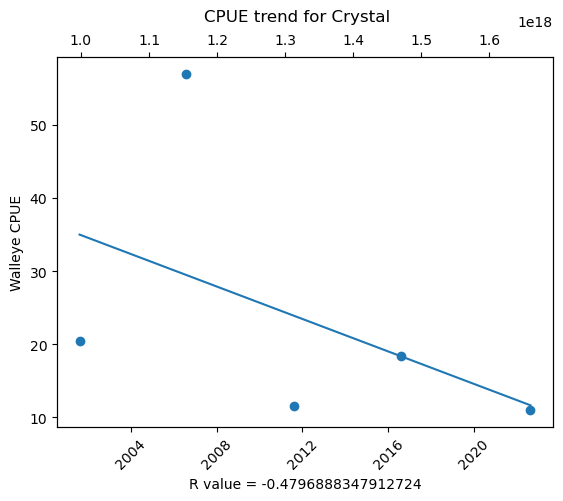

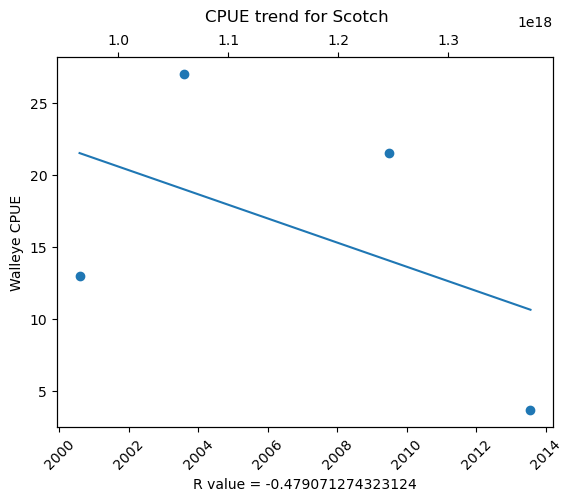

In [64]:
#plot regression lines for each lake CPUE over time
plot_regression_scatter(fish_cpue, cpue_sdate, cpue_ndate, lakes, "CPUE")

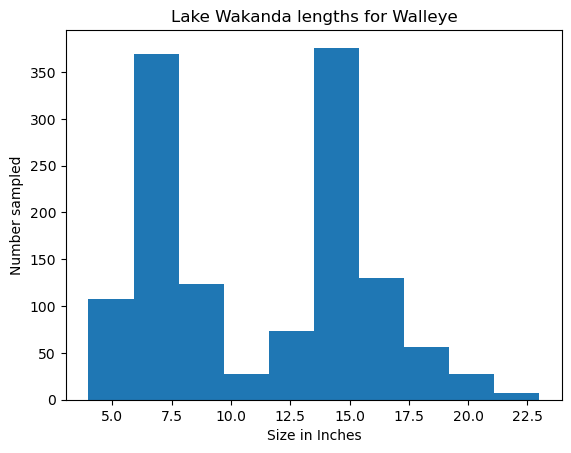

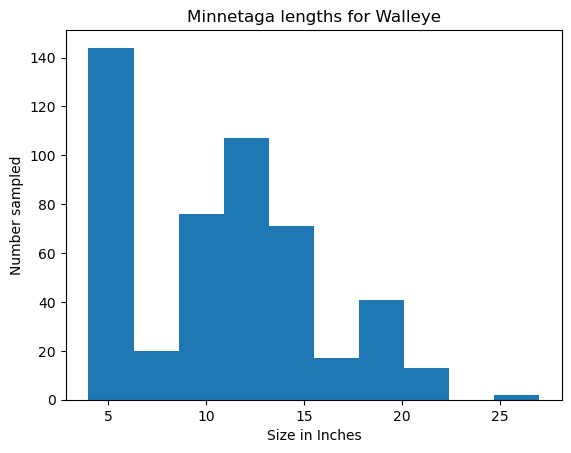

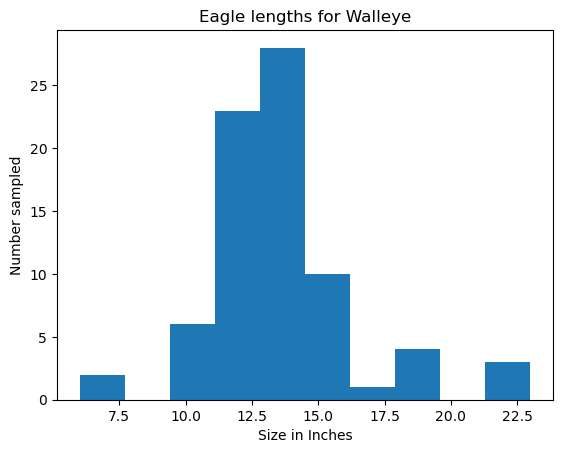

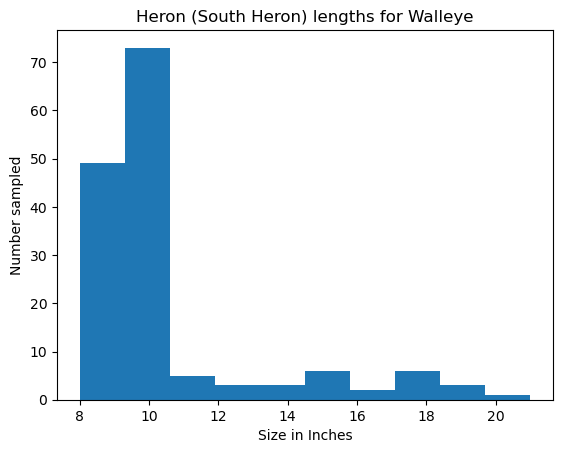

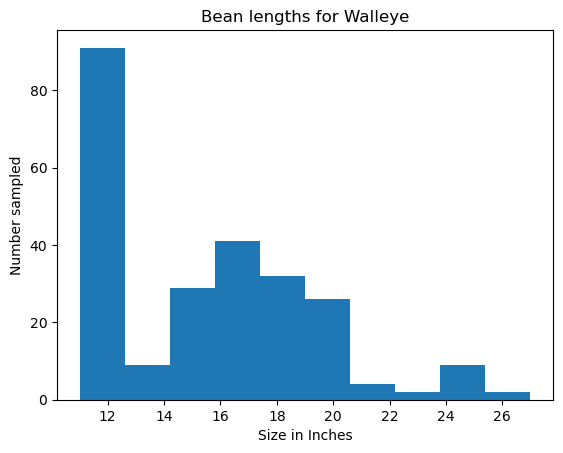

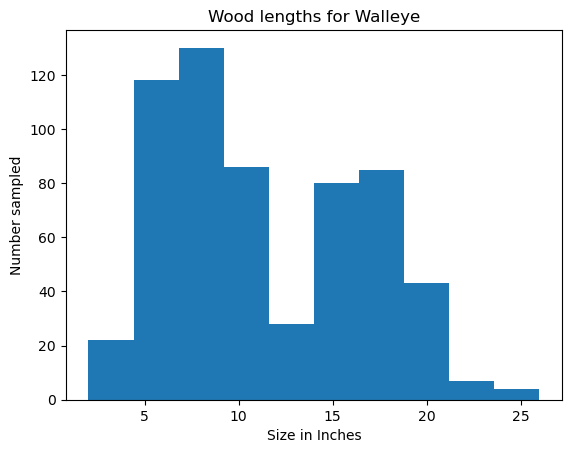

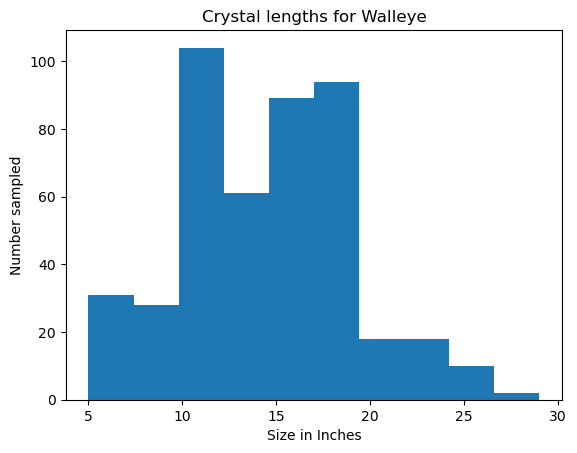

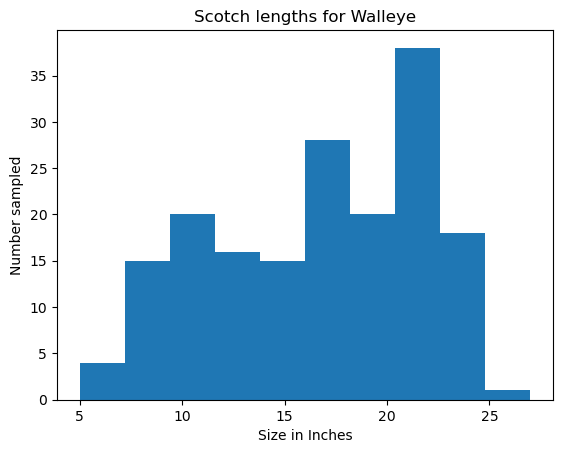

In [65]:
#plot histograms of lengths per lake
plot_length_hist(lengthdict)

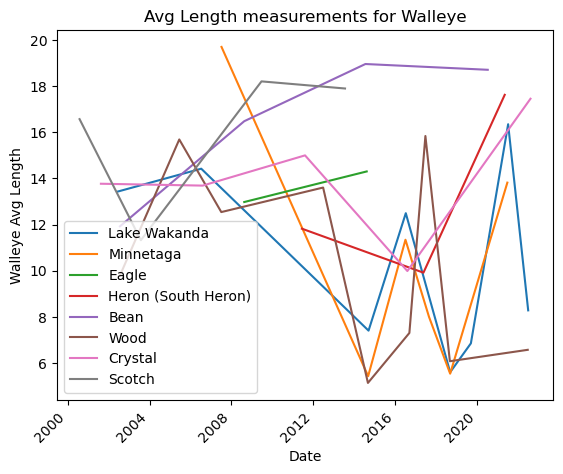

In [72]:
#plot scatter of average fish lengths per lake
plot_scatter(fishavglength, length_sdate, lakes, "Avg Length")

Notes:


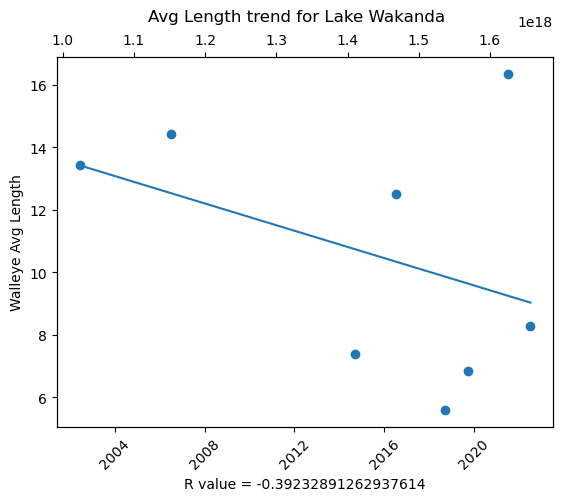

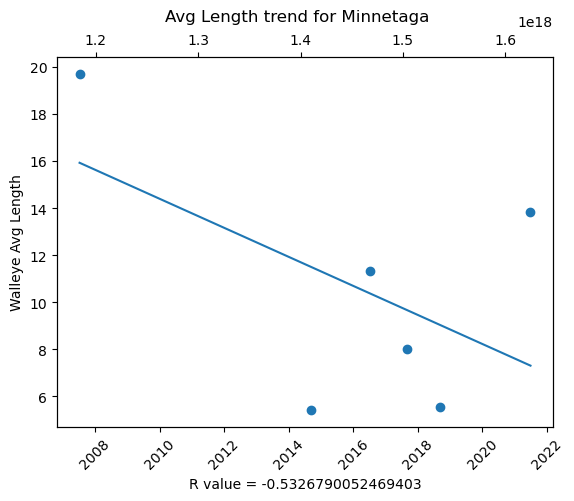

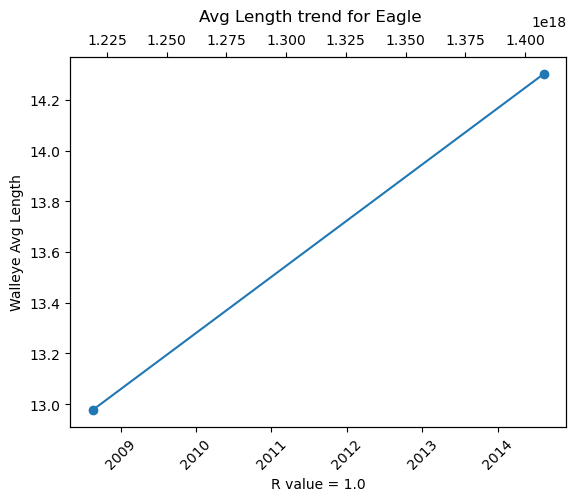

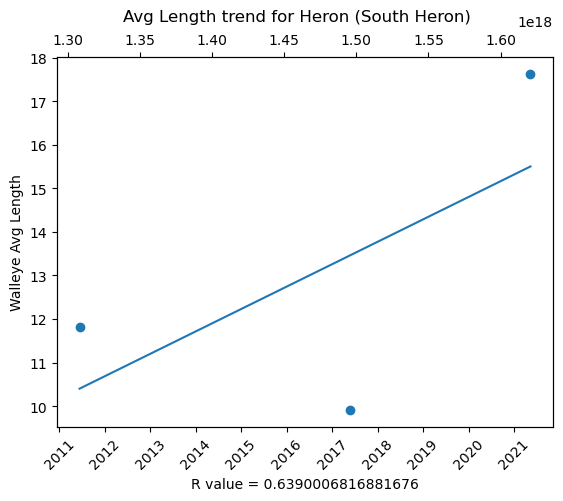

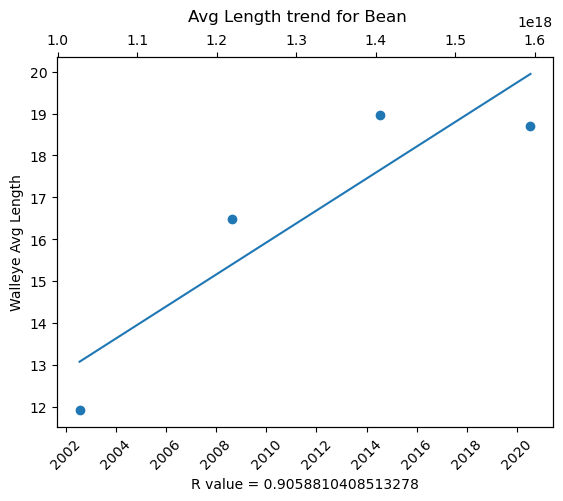

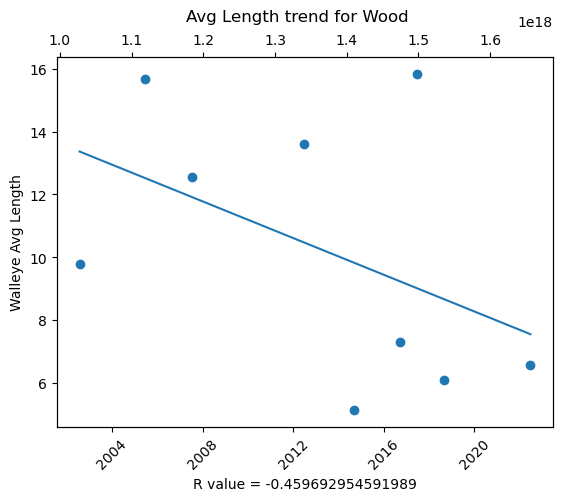

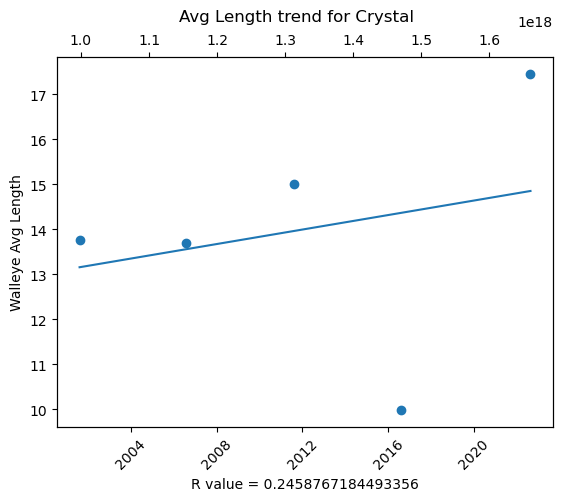

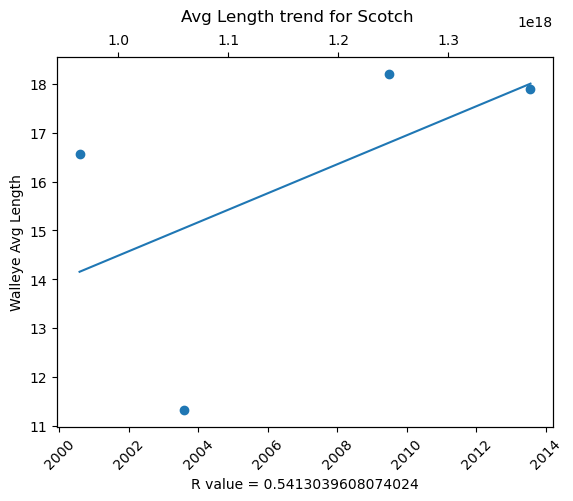

In [67]:
#plot regression lines for each lake average fish length over time
plot_regression_scatter(fishavglength, length_sdate, length_ndate, lakes, "Avg Length")

#### End of Report